<a href="https://colab.research.google.com/github/promckkon/1DCNN/blob/main/MK-catboost%20with%200%20NOISE%20in%20CWRU%20Dataset%2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [70]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_10_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F2_Ball_14.mat
['F2_Ball_14']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F1_Ball_7.mat


/tmp/ipython-input-409807264.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['F2_Ball_14' 'F1_Ball_7']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F0_Normal.mat
['F2_Ball_14' 'F1_Ball_7' 'F0_Normal']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F4_InnerRace_7.mat
['F2_Ball_14' 'F1_Ball_7' 'F0_Normal' 'F4_InnerRace_7']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F3_Ball_21.mat
['F2_Ball_14' 'F1_Ball_7' 'F0_Normal' 'F4_InnerRace_7' 'F3_Ball_21']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F7_OuterRace_7.mat
['F2_Ball_14' 'F1_Ball_7' 'F0_Normal' 'F4_InnerRace_7' 'F3_Ball_21'
 'F7_OuterRace_7']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F6_InnerRace_21.mat
['F2_Ball_14' 'F1_Ball_7' 'F0_Normal' 'F4_InnerRace_7' 'F3_Ball_21'
 'F7_OuterRace_7' 'F6_InnerRace_21']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F5_InnerRace_14.mat
['F2_Ball_14' 'F1_Ball_7' 'F0_Normal' 'F4_InnerRace_7' 'F3_Ball_21'
 'F7_OuterRace_7' 'F6_InnerRace_21' 'F5_InnerRace_14']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F9_OuterRace_21.mat
['F2_Ball_14' 'F1_Ball_7' 'F0_Normal' 'F4_Inn

# Multi-Kernel Deep 1D-CNN

In [71]:
pip install tensorflow

In [72]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [73]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify


cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=100, activation='relu', input_shape=(X.shape[1],X.shape[2])))
cnn_model.add(Conv1D(filters=32, kernel_size=50, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))

cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Number of output classes (no_classes): 10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 2607, 64)       │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 2558, 32)       │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2558, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 81856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │     8,185,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,295,606 (31.65 MB)

 Trainable params: 8,295,606 (31.65 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
batch_size =100
epochs =20
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 642ms/step - accuracy: 0.1140 - loss: 2.2218 - val_accuracy: 0.2689 - val_loss: 1.9263
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.2282 - loss: 1.8602 - val_accuracy: 0.3358 - val_loss: 1.5682
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4199 - loss: 1.4263 - val_accuracy: 0.5736 - val_loss: 1.0991
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6376 - loss: 0.9463 - val_accuracy: 0.5706 - val_loss: 1.1073
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6720 - loss: 0.8750 - val_accuracy: 0.7949 - val_loss: 0.6118
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8610 - loss: 0.4051 - val_accuracy: 0.8247 - val_loss: 0.4587
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8938 - loss: 0.2836 - val_accuracy: 0.8499 - val_loss: 0.4122
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9589 - loss: 0.1193 - val_accuracy: 0.8440 -

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_120
Received: inputs=('Tensor(shape=(32, 2706, 1))', 'Tensor(shape=(32, 2706, 1))', 'Tensor(shape=(32, 2706, 1))')
  warnings.warn(msg)


40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_120
Received: inputs=('Tensor(shape=(None, 2706, 1))', 'Tensor(shape=(None, 2706, 1))', 'Tensor(shape=(None, 2706, 1))')
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Train Accuracy: 0.9987
Test  Accuracy: 0.9079

Classification Report - Training Set:
                 precision    recall  f1-score   support

      F0_Normal       1.00      1.00      1.00       156
      F1_Ball_7       1.00      1.00      1.00       159
     F2_Ball_14       1.00      1.00      1.00       161
     F3_Ball_21       1.00      0.99      0.99       149
 F4_InnerRace_7       1.00      1.00      1.00       163
F5_InnerRace_14       1.00      1.00      1.00       154
F6_InnerRace_21       1.00      1.00      1.00       158
 F7_OuterRace_7       1.00      1.00      1.00       138
F8_OuterRace_14       1.00      1.00      1.00       160
F9_OuterRace_21       0.99      1.00      0.99       172

       accuracy                           1.00      1570
      macro avg       1.00      1.00      1.00      1570
   weighted avg       1.00      1.00      1.00      1570


Classification Report - Test Set:

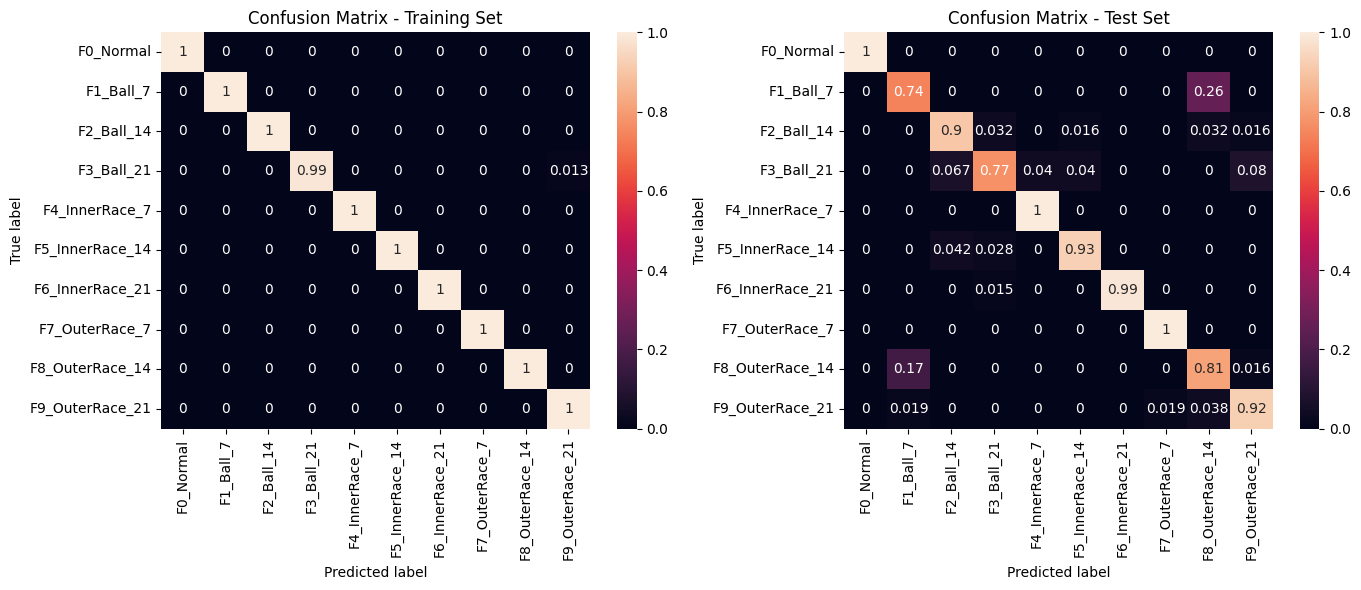

In [76]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 把 one-hot / 機率轉回原始類別名稱
def inv_Transform_result(y):
    y_idx = y.argmax(axis=1)          # 取出最大機率的類別索引
    y_label = encoder.inverse_transform(y_idx)  # 用你原本的 encoder 還原成 label
    return y_label


# === 1. 取得 Train / Test 的預測機率 ===
y_train_prob = cnn_model.predict([X_train, X_train, X_train])
y_test_prob  = cnn_model.predict([X_test,  X_test,  X_test])

# === 2. 機率 / one-hot 轉成類別名稱 ===
y_train_pred = inv_Transform_result(y_train_prob)
y_test_pred  = inv_Transform_result(y_test_prob)

Y_train_true = inv_Transform_result(y_train)   # y_train 是 one-hot
Y_test_true  = inv_Transform_result(y_test)    # y_test 也是 one-hot


# === 3. 計算 Train / Test accuracy ===
train_acc = accuracy_score(Y_train_true, y_train_pred)
test_acc  = accuracy_score(Y_test_true,  y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}\n")


# === 4. 印出 Train / Test 的 precision / recall / F1-score ===
print("Classification Report - Training Set:")
print(classification_report(
    Y_train_true,
    y_train_pred,
    target_names=encoder.classes_
))

print("\nClassification Report - Test Set:")
print(classification_report(
    Y_test_true,
    y_test_pred,
    target_names=encoder.classes_
))


# === 5. 畫出 Train / Test 的混淆矩陣 ===
cm_train = confusion_matrix(Y_train_true, y_train_pred, normalize='true')
cm_test  = confusion_matrix(Y_test_true,  y_test_pred,  normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train,
            annot=True,
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_,
            ax=axes[0])
axes[0].set_title("Confusion Matrix - Training Set")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")

sns.heatmap(cm_test,
            annot=True,
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_,
            ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")

plt.tight_layout()
plt.show()

In [77]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

AttributeError: The layer sequential_6 has never been called and thus has no defined input.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}',s=20, alpha=0.7,edgecolors='none')

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(
    loc='upper left',             # 以左上為基準

    borderaxespad=0.,
    fontsize=6,                   # 再縮小字體
    title_fontsize=7,
    markerscale=1,              # 圖例裡的小點也縮小
    framealpha=0.8                # 半透明，避免太遮
)
plt.tight_layout()
plt.show()

Statistical Features

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'")


In [ ]:
balanced_df.shape

In [ ]:
balanced_df=balanced_df.sort_values(by='fault')

In [ ]:
balanced_df

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [ ]:
tSNE_representation

In [ ]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

In [ ]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [ ]:
tSNEdf

Combined Features

In [ ]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


In [ ]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [ ]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

y_shuffled = np.random.permutation(y)

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2    ,random_state=42,
    shuffle=True,
    stratify=y  )

In [ ]:
!pip install catboost

Deployment:

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

cat_model = CatBoostClassifier(
    iterations=100,
    depth=4,
    learning_rate=0.01,
    l2_leaf_reg=5,
    bagging_temperature=1.5,
    random_strength=1.5,
    random_seed=42,
    verbose=50
)

# === 訓練模型 ===
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # 用測試集當驗證集看學習曲線
    plot=True                   # 在 Colab 畫出學習曲線
)
# ========= 1. 對 Train / Test 都做預測 =========
y_train_pred = cat_model.predict(X_train)
y_test_pred  = cat_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}\n")

# ========= 2. 印出 Train Set 的分類報告 =========
print("Classification Report - Training Set:")
print(classification_report(y_train, y_train_pred))

# ========= 3. 印出 Test Set 的分類報告 =========
print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_test_pred))

# ========= 4. 混淆矩陣：Train / Test 各一個 =========
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test,  y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Training Set")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")

plt.tight_layout()
plt.show()